# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Covid-19 has been a new viral disease that has impact the world in 2020. World has come to a standstill with travel restrictions in all countries, tens of thousands are infected everyday and thousands being deceased. Even after ten months start of this pandemic, the number of cases are still on rise. 

In this project we will try to find the Covid cases in Ontario. Specifically, in this report we will review few of the **health center regions in Ontario province** that have huge number of cases and we use geocoding to view the **availablility of hopsitial distribution** in this areas.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. And decide the possible location to estabilish  temporary medical centers to handle emergency medical crisis.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of Covid cases in each of Health region by age groups
* number of hospitals and distance to Health region in the neighborhood
* distance of hpostial from Health Center

We decided to use regularly spaced grid of locations, centered around Health Region.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* Latest Covid-19 cases from the **Torono Health Region** offical website.

### Importing folium

In [9]:
!pip install folium

     |████████████████████████████████| 93 kB 4.3 MB/s  eta 0:00:01


### Importing Libraries

In [10]:
import pandas as pd
import numpy as np

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                         /                    failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.9|3.6.9|3.6.9|3.6.9|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.9,<3.10.0a0|>=3.8,<3.9.0a0|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|3.4.*',build='0_73_pypy|1_73_pypy|2_73_pypy|3_73_pypy']
  - geopy -> python[version='2.7.*|3.4.*|3.5.*|3.6.*']
  - rsa -> python[version='2.7.*|3.4.*|3.5.*|

## Methodology <a name="methodology"></a>

In this project we will utilise our efforts on detecting number of hospitals in Health regions with major covid cases, particulary Toronto Health Region. We will take data with proxmity of 5kms around the region.

In first step we will collected the COVID-19 cases data from the **Toronto Health Region**.

Second step in our analysis will be splitting data into two parts namely, first wave and second waves.

In third  step, we will compare the number of cases for each health region in both waves and take the region with most number of cases in the second wave.

In final step, we will create an impact circlemarker with number of cases as marker. Each radius of the circle will be proportional to its number of cases. We will consider the circle with highest radius and search the hospitals near the health region within 5kms radius using foursqaure api. Once we draw circle with the available data, we will conclude the area where there is more need of hospitals or emergency medical centers.

## Analysis <a name="analysis"></a>

Now lets download the latest covid-19 cases data from Toronto Health official website and perform some basic explanatory data analysis:

In [11]:
data = pd.read_csv('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv')
data

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-30,2020-11-01,2020-11-01,2020-10-31,20s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
1,2,2020-11-14,2020-11-17,2020-11-17,2020-11-15,30s,FEMALE,OB,Resolved,Yes,2234,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,www.hnhu.org,42.847825,-80.303815
2,3,2020-10-30,2020-11-02,2020-11-02,2020-10-31,60s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
3,4,2020-11-09,2020-11-14,2020-11-15,2020-11-14,70s,MALE,CC,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
4,5,2020-11-10,2020-11-14,2020-11-14,2020-11-14,70s,FEMALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116487,116488,2020-10-08,2020-10-10,2020-10-10,2020-10-09,20s,FEMALE,No known epi link,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
116488,116489,2020-04-11,2020-04-12,2020-04-12,NaN,90s,FEMALE,OB,Fatal,Yes,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
116489,116490,2020-04-27,2020-04-28,2020-06-10,NaN,50s,FEMALE,CC,Resolved,NaN,2237,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,www.hamilton.ca/publichealth,43.257631,-79.871341
116490,116491,2020-04-18,2020-04-28,2020-04-27,2020-04-27,80s,FEMALE,OB,Fatal,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912


Storing data with Report date is blank

In [25]:
data_nocase = data[pd.isnull(data['Test_Reported_Date'])]
data_nocase

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
95,96,2020-11-02,2020-11-02,NaN,NaN,40s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
96,97,2020-10-26,2020-11-02,NaN,NaN,30s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
99,100,2020-10-28,2020-11-02,NaN,NaN,50s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
112,113,2020-11-02,2020-11-02,NaN,NaN,50s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
141,142,2020-11-02,2020-11-02,NaN,NaN,40s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116157,116158,2020-05-12,2020-05-25,NaN,NaN,20s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
116197,116198,2020-10-19,2020-10-21,NaN,2020-10-19,<20,FEMALE,CC,Resolved,NaN,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912
116203,116204,2020-08-23,2020-08-27,NaN,NaN,50s,FEMALE,CC,Resolved,NaN,2243,"Leeds, Grenville and Lanark District Health Unit",458 Laurier Boulevard,Brockville,K6V 7A3,www.healthunit.org,44.615843,-75.702833
116286,116287,2020-11-10,2020-11-16,NaN,NaN,<20,MALE,CC,Resolved,NaN,2270,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,www.york.ca/wps/portal/yorkhome/health/,44.048023,-79.480239


Moving data into a dataframe with only having Reported Date

In [26]:
df = data[pd.notnull(data['Test_Reported_Date'])]
df

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-30,2020-11-01,2020-11-01,2020-10-31,20s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
1,2,2020-11-14,2020-11-17,2020-11-17,2020-11-15,30s,FEMALE,OB,Resolved,Yes,2234,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,www.hnhu.org,42.847825,-80.303815
2,3,2020-10-30,2020-11-02,2020-11-02,2020-10-31,60s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
3,4,2020-11-09,2020-11-14,2020-11-15,2020-11-14,70s,MALE,CC,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
4,5,2020-11-10,2020-11-14,2020-11-14,2020-11-14,70s,FEMALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116487,116488,2020-10-08,2020-10-10,2020-10-10,2020-10-09,20s,FEMALE,No known epi link,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
116488,116489,2020-04-11,2020-04-12,2020-04-12,NaN,90s,FEMALE,OB,Fatal,Yes,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
116489,116490,2020-04-27,2020-04-28,2020-06-10,NaN,50s,FEMALE,CC,Resolved,NaN,2237,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,www.hamilton.ca/publichealth,43.257631,-79.871341
116490,116491,2020-04-18,2020-04-28,2020-04-27,2020-04-27,80s,FEMALE,OB,Fatal,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912


Sorting data with Row ID

In [31]:
df.set_index('Row_ID')
df

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-30,2020-11-01,2020-11-01,2020-10-31,20s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
1,2,2020-11-14,2020-11-17,2020-11-17,2020-11-15,30s,FEMALE,OB,Resolved,Yes,2234,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,www.hnhu.org,42.847825,-80.303815
2,3,2020-10-30,2020-11-02,2020-11-02,2020-10-31,60s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
3,4,2020-11-09,2020-11-14,2020-11-15,2020-11-14,70s,MALE,CC,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
4,5,2020-11-10,2020-11-14,2020-11-14,2020-11-14,70s,FEMALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115094,116488,2020-10-08,2020-10-10,2020-10-10,2020-10-09,20s,FEMALE,No known epi link,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
115095,116489,2020-04-11,2020-04-12,2020-04-12,NaN,90s,FEMALE,OB,Fatal,Yes,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
115096,116490,2020-04-27,2020-04-28,2020-06-10,NaN,50s,FEMALE,CC,Resolved,NaN,2237,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,www.hamilton.ca/publichealth,43.257631,-79.871341
115097,116491,2020-04-18,2020-04-28,2020-04-27,2020-04-27,80s,FEMALE,OB,Fatal,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912


Resetting Index column

In [32]:
df.reset_index(level=None, drop=True, inplace=True)
df

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-30,2020-11-01,2020-11-01,2020-10-31,20s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
1,2,2020-11-14,2020-11-17,2020-11-17,2020-11-15,30s,FEMALE,OB,Resolved,Yes,2234,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,www.hnhu.org,42.847825,-80.303815
2,3,2020-10-30,2020-11-02,2020-11-02,2020-10-31,60s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
3,4,2020-11-09,2020-11-14,2020-11-15,2020-11-14,70s,MALE,CC,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
4,5,2020-11-10,2020-11-14,2020-11-14,2020-11-14,70s,FEMALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115094,116488,2020-10-08,2020-10-10,2020-10-10,2020-10-09,20s,FEMALE,No known epi link,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
115095,116489,2020-04-11,2020-04-12,2020-04-12,NaN,90s,FEMALE,OB,Fatal,Yes,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
115096,116490,2020-04-27,2020-04-28,2020-06-10,NaN,50s,FEMALE,CC,Resolved,NaN,2237,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,www.hamilton.ca/publichealth,43.257631,-79.871341
115097,116491,2020-04-18,2020-04-28,2020-04-27,2020-04-27,80s,FEMALE,OB,Fatal,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912


On observing the covid cases trend, cases count in June was low before it started to spike up, which is called as second wave. So spliting our data as two part i,e., first wave and second.

In [33]:
df_fst = df[(df['Case_Reported_Date'])<'2020-06-30']
df_fst

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
8917,9060,2020-05-10,2020-05-22,2020-05-22,NaN,80s,MALE,CC,Resolved,NaN,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
39758,40245,2020-01-22,2020-01-23,2020-01-27,2020-01-25,50s,FEMALE,Travel,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
39759,40246,2020-01-21,2020-01-23,2020-01-27,2020-01-23,50s,MALE,Travel,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
39760,40247,2020-01-24,2020-01-24,2020-02-03,2020-01-24,20s,FEMALE,Travel,Resolved,NaN,2244,Middlesex-London Health Unit,50 King Street,London,N6A 5L7,www.healthunit.com,42.981468,-81.254016
39761,40248,2020-02-05,2020-02-21,2020-02-24,2020-02-22,20s,FEMALE,Travel,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115091,116485,2020-04-27,2020-04-27,2020-04-27,NaN,50s,FEMALE,OB,Resolved,Yes,2261,Sudbury & District Health Unit,1300 Paris Street,Sudbury,P3E 3A3,www.phsd.ca,46.466092,-80.998059
115095,116489,2020-04-11,2020-04-12,2020-04-12,NaN,90s,FEMALE,OB,Fatal,Yes,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
115096,116490,2020-04-27,2020-04-28,2020-06-10,NaN,50s,FEMALE,CC,Resolved,NaN,2237,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,www.hamilton.ca/publichealth,43.257631,-79.871341
115097,116491,2020-04-18,2020-04-28,2020-04-27,2020-04-27,80s,FEMALE,OB,Fatal,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912


Second wave cases 

In [34]:
df_snd = df[(df['Case_Reported_Date'])>'2020-07-01']
df_snd

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-10-30,2020-11-01,2020-11-01,2020-10-31,20s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
1,2,2020-11-14,2020-11-17,2020-11-17,2020-11-15,30s,FEMALE,OB,Resolved,Yes,2234,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,www.hnhu.org,42.847825,-80.303815
2,3,2020-10-30,2020-11-02,2020-11-02,2020-10-31,60s,MALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
3,4,2020-11-09,2020-11-14,2020-11-15,2020-11-14,70s,MALE,CC,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
4,5,2020-11-10,2020-11-14,2020-11-14,2020-11-14,70s,FEMALE,OB,Resolved,Yes,4913,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,www.swpublichealth.ca,42.777804,-81.151156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115087,116481,2020-09-15,2020-09-17,2020-09-17,2020-09-15,50s,MALE,OB,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
115088,116482,2020-11-27,2020-11-28,2020-11-28,2020-11-27,50s,FEMALE,No known epi link,Not Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
115092,116486,2020-10-28,2020-10-30,2020-10-28,2020-10-28,90s,MALE,OB,Resolved,Yes,2251,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912
115093,116487,2020-08-03,2020-08-17,2020-08-17,2020-08-15,30s,MALE,No known epi link,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


We want to review covid cases based on the Health region

In [35]:
new=df_fst.groupby('Reporting_PHU').count()
new.sort_values('Case_Reported_Date', inplace=True)
new

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
Reporting_PHU,,,,,,,,,,,,,,,,,
Timiskaming Health Unit,16,16,16,16,0,16,16,16,16,7,16,16,16,16,16,16,16
Algoma Public Health Unit,24,24,24,24,0,24,24,24,24,5,24,24,24,24,24,24,24
Renfrew County and District Health Unit,25,25,25,25,0,25,25,25,25,8,25,25,25,25,25,25,25
North Bay Parry Sound District Health Unit,29,29,29,29,0,29,29,29,29,3,29,29,29,29,29,29,29
Northwestern Health Unit,37,37,37,37,0,37,37,37,37,13,37,37,37,37,37,37,37
Hastings and Prince Edward Counties Health Unit,42,42,42,42,0,42,42,42,42,15,42,42,42,42,42,42,42
Huron Perth District Health Unit,58,58,58,58,0,58,58,58,58,21,58,58,58,58,58,58,58
Sudbury & District Health Unit,64,64,64,64,0,64,64,64,64,18,64,64,64,64,64,64,64
Porcupine Health Unit,67,67,67,67,0,67,67,67,67,16,67,67,67,67,67,67,67


Number of Cases for each health region in Ontario during first wave

In [36]:
df_grp1 = df_fst['Reporting_PHU'].value_counts().to_frame()
df_grp1.rename(columns={"":"Health_Region","Reporting_PHU": "First_Wave"}, inplace=True)
df_grp1 

,First_Wave
Toronto Public Health,13036
Peel Public Health,5778
York Region Public Health Services,2950
Ottawa Public Health,2030
Durham Region Health Department,1690
Windsor-Essex County Health Unit,1523
"Region of Waterloo, Public Health",1283
Hamilton Public Health Services,825
Niagara Region Public Health Department,752
Halton Region Health Department,749


Number of cases for each health region during second wave

In [37]:
df_grp2 = df_snd['Reporting_PHU'].value_counts().to_frame()
df_grp2.rename(columns={'Reporting_PHU': 'Second_Wave'}, inplace=True)
df_grp2

,Second_Wave
Toronto Public Health,26428
Peel Public Health,19505
York Region Public Health Services,7689
Ottawa Public Health,5913
Halton Region Health Department,2721
Durham Region Health Department,2714
Hamilton Public Health Services,2327
"Region of Waterloo, Public Health",2188
Windsor-Essex County Health Unit,1998
Simcoe Muskoka District Health Unit,1481


Comparing both First wave and Second wave cases for all health regions

In [38]:
df_grp1= pd.concat([df_grp1, df_grp2], axis=1, join='inner')
df_grp1

,First_Wave,Second_Wave
Toronto Public Health,13036,26428
Peel Public Health,5778,19505
York Region Public Health Services,2950,7689
Ottawa Public Health,2030,5913
Durham Region Health Department,1690,2714
Windsor-Essex County Health Unit,1523,1998
"Region of Waterloo, Public Health",1283,2188
Hamilton Public Health Services,825,2327
Niagara Region Public Health Department,752,1378
Halton Region Health Department,749,2721


Selecting the health regions where the second wave cases are more than first wave

In [39]:
df_hghcase = df_grp1[(df_grp1['Second_Wave'])>(df_grp1['First_Wave'])]
df_hghcase

,First_Wave,Second_Wave
Toronto Public Health,13036,26428
Peel Public Health,5778,19505
York Region Public Health Services,2950,7689
Ottawa Public Health,2030,5913
Durham Region Health Department,1690,2714
Windsor-Essex County Health Unit,1523,1998
"Region of Waterloo, Public Health",1283,2188
Hamilton Public Health Services,825,2327
Niagara Region Public Health Department,752,1378
Halton Region Health Department,749,2721


Importing matploat libraries

In [40]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.2


Plotting both First wave and Second wave cases with respective to each health region

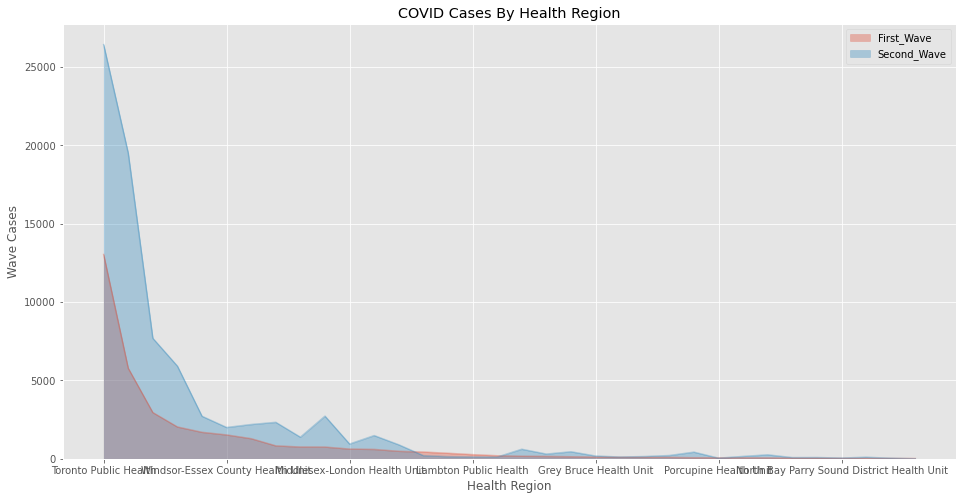

In [42]:
df_grp1.index = df_grp1.index.map(str) # let's change the index values of df_top5 to type integer for plotting
df_grp1.plot(kind='area', alpha = 0.35,
             stacked=False,
             figsize=(16, 8), # pass a tuple (x, y) size
             )

plt.title('COVID Cases By Health Region')
plt.ylabel('Wave Cases')
plt.xlabel('Health Region')

plt.show()

Bar plot high cases 

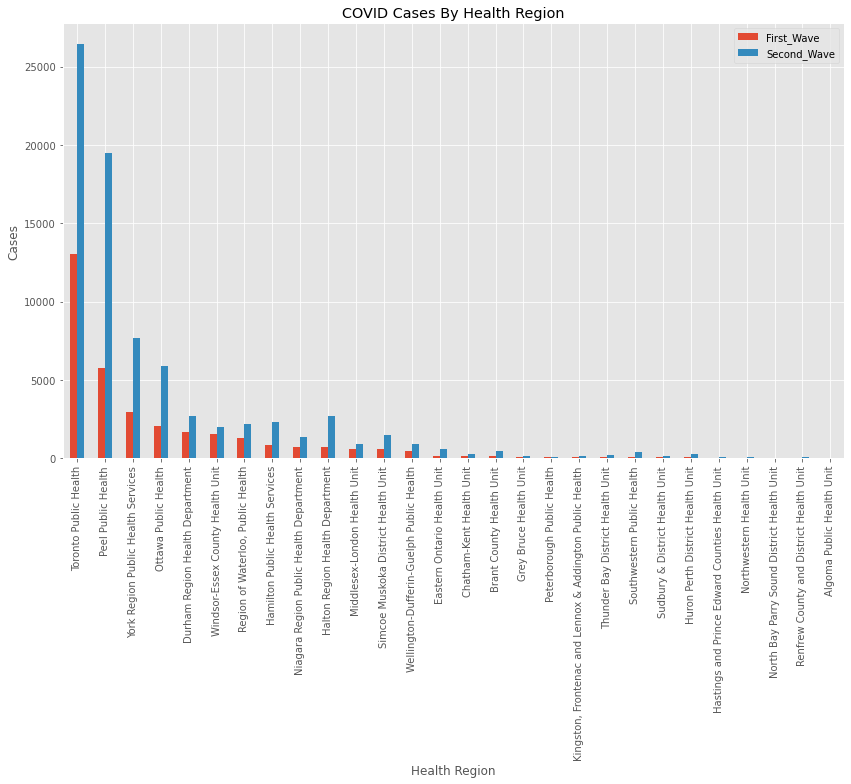

In [43]:
df_hghcase.plot(kind='bar', figsize=(14, 8))

plt.xlabel('Health Region') # add to x-label to the plot
plt.ylabel('Cases') # add y-label to the plot
plt.title('COVID Cases By Health Region') # add title to the plot

plt.show()

Removing not required columns from the data

In [44]:
df_age1 = df_fst.drop(['Accurate_Episode_Date','Case_Reported_Date','Test_Reported_Date','Specimen_Date','Outbreak_Related','Outcome1', 'Case_AcquisitionInfo', 'Row_ID', 'Reporting_PHU_Address','Reporting_PHU_City','Reporting_PHU_Postal_Code','Reporting_PHU_Website','Reporting_PHU_Latitude','Reporting_PHU_Longitude','Client_Gender'], axis=1)
df_age1

,Age_Group,Reporting_PHU_ID,Reporting_PHU
8917,80s,2230,Durham Region Health Department
39758,50s,3895,Toronto Public Health
39759,50s,3895,Toronto Public Health
39760,20s,2244,Middlesex-London Health Unit
39761,20s,3895,Toronto Public Health
...,...,...,...
115091,50s,2261,Sudbury & District Health Unit
115095,90s,2230,Durham Region Health Department
115096,50s,2237,Hamilton Public Health Services
115097,80s,2251,Ottawa Public Health


Formatting Age numbers to required format

In [45]:
df_age1['Age_Group'] = df_age1['Age_Group'].replace(['20s','30s','40s','50s','60s','70s','80s','90s'],[20,30,40,50,60,70,80,90])
df_age1

,Age_Group,Reporting_PHU_ID,Reporting_PHU
8917,80,2230,Durham Region Health Department
39758,50,3895,Toronto Public Health
39759,50,3895,Toronto Public Health
39760,20,2244,Middlesex-London Health Unit
39761,20,3895,Toronto Public Health
...,...,...,...
115091,50,2261,Sudbury & District Health Unit
115095,90,2230,Durham Region Health Department
115096,50,2237,Hamilton Public Health Services
115097,80,2251,Ottawa Public Health


In [46]:
df_age1.groupby(df_age1.columns.tolist(),as_index=False).size()
df_age1.reset_index()

,index,Age_Group,Reporting_PHU_ID,Reporting_PHU
0,8917,80,2230,Durham Region Health Department
1,39758,50,3895,Toronto Public Health
2,39759,50,3895,Toronto Public Health
3,39760,20,2244,Middlesex-London Health Unit
4,39761,20,3895,Toronto Public Health
...,...,...,...,...
34814,115091,50,2261,Sudbury & District Health Unit
34815,115095,90,2230,Durham Region Health Department
34816,115096,50,2237,Hamilton Public Health Services
34817,115097,80,2251,Ottawa Public Health


In [47]:
dff=pd.DataFrame(df_age1.groupby(df_age1.columns.tolist()).size().reset_index().\
    rename(columns={0:'Counts'}))
dff

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
0,20,2226,Algoma Public Health Unit,3
1,20,2227,Brant County Health Unit,24
2,20,2230,Durham Region Health Department,171
3,20,2233,Grey Bruce Health Unit,13
4,20,2234,Haldimand-Norfolk Health Unit,54
...,...,...,...,...
289,<20,2270,York Region Public Health Services,130
290,<20,3895,Toronto Public Health,536
291,<20,4913,Southwestern Public Health,3
292,<20,5183,Huron Perth District Health Unit,1


In [48]:
dff.sort_values('Counts', ascending=False, inplace=True)
dff

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
131,50,3895,Toronto Public Health,2096
97,40,3895,Toronto Public Health,1866
64,30,3895,Toronto Public Health,1804
31,20,3895,Toronto Public Health,1749
228,80,3895,Toronto Public Health,1465
...,...,...,...,...
244,90,2249,Northwestern Health Unit,1
249,90,2257,Renfrew County and District Health Unit,1
252,90,2263,Timiskaming Health Unit,1
258,90,4913,Southwestern Public Health,1


In [49]:
df_final=dff.head(100)
df_final

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
131,50,3895,Toronto Public Health,2096
97,40,3895,Toronto Public Health,1866
64,30,3895,Toronto Public Health,1804
31,20,3895,Toronto Public Health,1749
228,80,3895,Toronto Public Health,1465
...,...,...,...,...
162,60,2266,Wellington-Dufferin-Guelph Public Health,64
267,<20,2237,Hamilton Public Health Services,64
28,20,2266,Wellington-Dufferin-Guelph Public Health,62
212,80,2244,Middlesex-London Health Unit,62


In [50]:
df_age2 = pd.DataFrame(df_snd.drop(['Accurate_Episode_Date','Case_Reported_Date','Test_Reported_Date','Specimen_Date','Outbreak_Related','Outcome1', 'Case_AcquisitionInfo', 'Row_ID', 'Reporting_PHU_Address','Reporting_PHU_City','Reporting_PHU_Postal_Code','Reporting_PHU_Website','Reporting_PHU_Latitude','Reporting_PHU_Longitude','Client_Gender'], axis=1))
df_age2

,Age_Group,Reporting_PHU_ID,Reporting_PHU
0,20s,4913,Southwestern Public Health
1,30s,2234,Haldimand-Norfolk Health Unit
2,60s,4913,Southwestern Public Health
3,70s,4913,Southwestern Public Health
4,70s,4913,Southwestern Public Health
...,...,...,...
115087,50s,3895,Toronto Public Health
115088,50s,3895,Toronto Public Health
115092,90s,2251,Ottawa Public Health
115093,30s,3895,Toronto Public Health


In [51]:
df_age2['Age_Group'] = df_age2['Age_Group'].replace(['20s','30s','40s','50s','60s','70s','80s','90s'],[20,30,40,50,60,70,80,90])
df_age2

,Age_Group,Reporting_PHU_ID,Reporting_PHU
0,20,4913,Southwestern Public Health
1,30,2234,Haldimand-Norfolk Health Unit
2,60,4913,Southwestern Public Health
3,70,4913,Southwestern Public Health
4,70,4913,Southwestern Public Health
...,...,...,...
115087,50,3895,Toronto Public Health
115088,50,3895,Toronto Public Health
115092,90,2251,Ottawa Public Health
115093,30,3895,Toronto Public Health


In [52]:
df_age2.groupby(df_age2.columns.tolist(),as_index=False).size()
df_age2.reset_index()

,index,Age_Group,Reporting_PHU_ID,Reporting_PHU
0,0,20,4913,Southwestern Public Health
1,1,30,2234,Haldimand-Norfolk Health Unit
2,2,60,4913,Southwestern Public Health
3,3,70,4913,Southwestern Public Health
4,4,70,4913,Southwestern Public Health
...,...,...,...,...
79945,115087,50,3895,Toronto Public Health
79946,115088,50,3895,Toronto Public Health
79947,115092,90,2251,Ottawa Public Health
79948,115093,30,3895,Toronto Public Health


In [53]:
dff2=pd.DataFrame(df_age2.groupby(df_age2.columns.tolist()).size().reset_index().\
    rename(columns={0:'Counts'}))
dff2

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
0,20,2226,Algoma Public Health Unit,11
1,20,2227,Brant County Health Unit,99
2,20,2230,Durham Region Health Department,526
3,20,2233,Grey Bruce Health Unit,29
4,20,2234,Haldimand-Norfolk Health Unit,38
...,...,...,...,...
285,<20,4913,Southwestern Public Health,71
286,<20,5183,Huron Perth District Health Unit,34
287,UNKNOWN,2236,Halton Region Health Department,1
288,UNKNOWN,2246,Niagara Region Public Health Department,1


In [54]:
dff2.sort_values('Counts', ascending=False, inplace=True)
dff2

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
30,20,3895,Toronto Public Health,6076
18,20,2253,Peel Public Health,5238
63,30,3895,Toronto Public Health,4561
130,50,3895,Toronto Public Health,3729
96,40,3895,Toronto Public Health,3692
...,...,...,...,...
279,<20,2263,Timiskaming Health Unit,1
239,90,2249,Northwestern Health Unit,1
243,90,2257,Renfrew County and District Health Unit,1
166,70,2226,Algoma Public Health Unit,1


In [55]:
df_final2=dff2.head(100)
df_final2

,Age_Group,Reporting_PHU_ID,Reporting_PHU,Counts
30,20,3895,Toronto Public Health,6076
18,20,2253,Peel Public Health,5238
63,30,3895,Toronto Public Health,4561
130,50,3895,Toronto Public Health,3729
96,40,3895,Toronto Public Health,3692
...,...,...,...,...
79,40,2244,Middlesex-London Health Unit,93
22,20,2258,Eastern Ontario Health Unit,90
160,60,2266,Wellington-Dufferin-Guelph Public Health,86
233,90,2236,Halton Region Health Department,81


### Foursquare
Now that we want our location candidates, let's use Foursquare API to get info on hospitals in Toronto.

loaded Foursquare credentials

In [56]:
# The code was removed by Watson Studio for sharing.

Getting the Toronto Coordinates

In [57]:
address = 'Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6534817 -79.3839347


Imporing matplot libraries

In [58]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.2


Setting our Query result as Hospital and within the radius of 5Kms 

In [59]:
search_query = 'Hospital'
radius = 5000
print(search_query + ' .... OK!')

Hospital .... OK!


In [60]:
# The code was removed by Watson Studio for sharing.

Importing Reguest for Json

In [61]:
import requests
import random 

Storing search results

In [62]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fc5e1899fd1ad4010b58b6b'},
 'response': {'venues': [{'id': '4ad4c064f964a5206ef820e3',
    'name': 'The Hospital for Sick Children (SickKids)',
    'location': {'address': '555 University Ave.',
     'crossStreet': 'at Gerrard St.',
     'lat': 43.657498668962646,
     'lng': -79.3865121609307,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.657498668962646,
       'lng': -79.3865121609307}],
     'distance': 492,
     'postalCode': 'M5G 1X8',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['555 University Ave. (at Gerrard St.)',
      'Toronto ON M5G 1X8',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d196941735',
      'name': 'Hospital',
      'pluralName': 'Hospitals',
      'shortName': 'Hospital',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/medical_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-

In [63]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4ad4c064f964a5206ef820e3,The Hospital for Sick Children (SickKids),"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1606803849,False,555 University Ave.,at Gerrard St.,43.657499,-79.386512,"[{'label': 'display', 'lat': 43.65749866896264...",492,M5G 1X8,CA,Toronto,ON,Canada,"[555 University Ave. (at Gerrard St.), Toronto..."
1,4ad4c064f964a5206ff820e3,St. Michael's Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1606803849,False,30 Bond St,at Queen St E,43.653784,-79.377809,"[{'label': 'display', 'lat': 43.65378419391942...",494,M5B 1W8,CA,Toronto,ON,Canada,"[30 Bond St (at Queen St E), Toronto ON M5B 1W..."
2,4ad4c064f964a52070f820e3,Toronto General Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1606803849,False,190 Elizabeth St,at Gerrard St W,43.658762,-79.388292,"[{'label': 'display', 'lat': 43.65876218215914...",684,M5G 2C4,CA,Toronto,ON,Canada,"[190 Elizabeth St (at Gerrard St W), Toronto O..."
3,4af0615cf964a5208cdb21e3,Women's College Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1606803849,False,76 Grenville St.,at Bay St.,43.661491,-79.387602,"[{'label': 'display', 'lat': 43.66149084521543...",939,M5S 1B2,CA,Toronto,ON,Canada,"[76 Grenville St. (at Bay St.), Toronto ON M5S..."
4,4ae9bd8af964a520feb521e3,"Mount Sinai Hospital, Joseph and Wolf Lebovic ...","[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1606803849,False,60 Murray St,College & University,43.658247,-79.391473,"[{'label': 'display', 'lat': 43.65824708835551...",806,NaN,CA,Toronto,ON,Canada,"[60 Murray St (College & University), Toronto ..."


Filtering the search result for Hospital

In [64]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered = dataframe_filtered[dataframe_filtered['categories']=='Hospital']

dataframe_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,The Hospital for Sick Children (SickKids),Hospital,555 University Ave.,at Gerrard St.,43.657499,-79.386512,"[{'label': 'display', 'lat': 43.65749866896264...",492,M5G 1X8,CA,Toronto,ON,Canada,"[555 University Ave. (at Gerrard St.), Toronto...",4ad4c064f964a5206ef820e3
1,St. Michael's Hospital,Hospital,30 Bond St,at Queen St E,43.653784,-79.377809,"[{'label': 'display', 'lat': 43.65378419391942...",494,M5B 1W8,CA,Toronto,ON,Canada,"[30 Bond St (at Queen St E), Toronto ON M5B 1W...",4ad4c064f964a5206ff820e3
2,Toronto General Hospital,Hospital,190 Elizabeth St,at Gerrard St W,43.658762,-79.388292,"[{'label': 'display', 'lat': 43.65876218215914...",684,M5G 2C4,CA,Toronto,ON,Canada,"[190 Elizabeth St (at Gerrard St W), Toronto O...",4ad4c064f964a52070f820e3
3,Women's College Hospital,Hospital,76 Grenville St.,at Bay St.,43.661491,-79.387602,"[{'label': 'display', 'lat': 43.66149084521543...",939,M5S 1B2,CA,Toronto,ON,Canada,"[76 Grenville St. (at Bay St.), Toronto ON M5S...",4af0615cf964a5208cdb21e3
4,"Mount Sinai Hospital, Joseph and Wolf Lebovic ...",Hospital,60 Murray St,College & University,43.658247,-79.391473,"[{'label': 'display', 'lat': 43.65824708835551...",806,NaN,CA,Toronto,ON,Canada,"[60 Murray St (College & University), Toronto ...",4ae9bd8af964a520feb521e3
6,Toronto Western Hospital,Hospital,399 Bathurst St.,at Dundas St. West,43.653434,-79.406074,"[{'label': 'display', 'lat': 43.65343431584569...",1783,M5T 2S7,CA,Toronto,ON,Canada,"[399 Bathurst St. (at Dundas St. West), Toront...",4af2fb96f964a52086e921e3
7,Mount Sinai Hospital Women's and Infants' Depa...,Hospital,"700 University Ave., 3rd floor, Ontario Power ...",at College St.,43.659612,-79.390761,"[{'label': 'display', 'lat': 43.6596121502049,...",876,NaN,CA,Toronto,ON,Canada,"[700 University Ave., 3rd floor, Ontario Power...",4b1fbe8af964a5209e2824e3
11,Mount Sinai Hospital,Hospital,600 University Ave,NaN,43.657701,-79.389711,"[{'label': 'display', 'lat': 43.657701, 'lng':...",661,M5G 1X5,CA,Toronto,ON,Canada,"[600 University Ave, Toronto ON M5G 1X5, Canada]",4ad4c064f964a52071f820e3
13,St. Michael’s Hospital - Echocardiography,Hospital,NaN,NaN,43.654114,-79.377038,"[{'label': 'display', 'lat': 43.654114, 'lng':...",559,M5B,CA,Toronto,ON,Canada,"[Toronto ON M5B, Canada]",5bec6350e179103c976b35be
14,Dundas Euclid Animal Hospital,Hospital,840 Dundas St. W.,Euclid,43.651518,-79.409984,"[{'label': 'display', 'lat': 43.65151776470952...",2109,M6J 1V5,CA,Toronto,ON,Canada,"[840 Dundas St. W. (Euclid), Toronto ON M6J 1V...",4bce159acc8cd13ac7b6c3cf


In [65]:
dataframe_filtered.name

0             The Hospital for Sick Children (SickKids)
1                                St. Michael's Hospital
2                              Toronto General Hospital
3                              Women's College Hospital
4     Mount Sinai Hospital, Joseph and Wolf Lebovic ...
6                              Toronto Western Hospital
7     Mount Sinai Hospital Women's and Infants' Depa...
11                                 Mount Sinai Hospital
13            St. Michael’s Hospital - Echocardiography
14                        Dundas Euclid Animal Hospital
16            Inpatient Lounge - St. Michael's Hospital
17                                  St Michael Hospital
18                                Rouge Valley Hospital
20                    MRI Department Sick Kids Hospital
21                  Endoscopy Unit St Michaels Hospital
24             St Michael's Hospital - Gastroenterology
25                    Voice Clinic - St Mike's Hospital
26           Chemo Daycare (Princess Margaret Ho

Concatenating Health region data with its location coordinates

In [66]:
df_cnt=pd.DataFrame(df_snd[['Reporting_PHU','Reporting_PHU_Address','Reporting_PHU_City','Reporting_PHU_Postal_Code','Reporting_PHU_Latitude','Reporting_PHU_Longitude']])
df_cnt

,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,42.777804,-81.151156
1,Haldimand-Norfolk Health Unit,12 Gilbertson Drive,Simcoe,N3Y 4N5,42.847825,-80.303815
2,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,42.777804,-81.151156
3,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,42.777804,-81.151156
4,Southwestern Public Health,1230 Talbot Street,St. Thomas,N5P 1G9,42.777804,-81.151156
...,...,...,...,...,...,...
115087,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,43.656591,-79.379358
115088,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,43.656591,-79.379358
115092,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,45.345665,-75.763912
115093,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,43.656591,-79.379358


In [67]:
df_count=pd.DataFrame(df_cnt.groupby(df_cnt.columns.tolist()).size().reset_index().\
    rename(columns={0:'Counts'}))
df_count.sort_values('Counts', ascending=False, inplace=True)
df_count

,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Counts
30,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,43.656591,-79.379358,26428
20,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,43.647471,-79.708893,19505
33,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,44.048023,-79.480239,7689
19,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,45.345665,-75.763912,5913
8,Halton Region Health Department,1151 Bronte Road,Oakville,L6M 3Ll,43.413997,-79.744796,2721
3,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,43.898605,-78.940341,2714
9,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,43.257631,-79.871341,2327
23,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,43.462876,-80.520913,2188
32,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,42.308796,-83.033670,1998
25,Simcoe Muskoka District Health Unit,15 Sperling Drive,Barrie,L4M 6K9,44.410713,-79.686306,1481


In [68]:
df_final=df_count.head(10)
df_final

,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Counts
30,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,43.656591,-79.379358,26428
20,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,43.647471,-79.708893,19505
33,York Region Public Health Services,17250 Yonge Street,Newmarket,L3Y 6Z1,44.048023,-79.480239,7689
19,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,45.345665,-75.763912,5913
8,Halton Region Health Department,1151 Bronte Road,Oakville,L6M 3Ll,43.413997,-79.744796,2721
3,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,43.898605,-78.940341,2714
9,Hamilton Public Health Services,"110 King St. West, 2nd Floor",Hamilton,L8P 4S6,43.257631,-79.871341,2327
23,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,43.462876,-80.520913,2188
32,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,42.308796,-83.033670,1998
25,Simcoe Muskoka District Health Unit,15 Sperling Drive,Barrie,L4M 6K9,44.410713,-79.686306,1481


Creating a circular map with  Health Region as center with number of cases as impact circle

In [69]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the  Health Region

# add a red circle marker to represent the Toronto Health Region
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Toronto Public Health',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the number of cases as blue circle markers
for i in range(0,len(df_final)):
#for lat, lng in zip(df_final.Reporting_PHU_Latitude, df_final.Reporting_PHU_Longitude):
    folium.CircleMarker(
        location=[df_final.iloc[i]['Reporting_PHU_Latitude'], df_final.iloc[i]['Reporting_PHU_Longitude']],
        radius=df_final.iloc[i]['Counts']/100,
        color='blue',
        #popup=label,
        fill = True,
        fill_color='blue',
       # fill_opacity=0.6
    ).add_to(venues_map)


# display map
venues_map

Marking Hospitals around the Toronoto Health Region 

In [70]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate hospital map centred around the Toronto Health Region

# add a red circle marker to represent the Toronto Health Region
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Toronto Public Health',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Hospital as blue circle markers
for lat, lng in zip(dataframe_filtered.lat, dataframe_filtered.lng):
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        color='blue',
        #popup=label,
        fill = True,
        fill_color='blue',
       # fill_opacity=0.6
    ).add_to(venues_map)


# display map
venues_map

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of hospital in Toronto Health Region(~5000 raduis to the region) which being the biggest Health region of the Ontario province 


Results of the report clearly showcase the distribution of hospitals around the health region are not uniformly distributed. As we can see, most of the hospitals are concentrated at north-west or north of health region, leaving no hospital coverage towards south and south-west.

## Conclusion <a name="conclusion"></a>

Aim of this project was to identify hospital distribution around the Toronto Health Region, which is having the highest number of COVID-19 cases now.

Finally we can conclude that, there is great deal of establishing new or temporary hospitals around the south-west or south of this health region to allocate equal amount of health facilities and provide emergency services available to edlerly and vunerable group in the region.